# Contents

We train an LSTM with gumbel-sigmoid gates on a toy language modelling problem.
Such LSTM can than be binarized to reach signifficantly greater speed.

In [1]:
%env THEANO_FLAGS="device=gpu3"

env: THEANO_FLAGS="device=gpu3"


In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os

Using gpu device 3: GeForce GTX 1080 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


# Generate mtg cards
* Regular RNN language modelling done by LSTM with "binary" gates

In [3]:
start_token = " "

with open("mtg_card_names.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]
    

In [4]:
print 'n samples = ',len(names)
for x in names[::1000]:
    print x

n samples =  16714
 [1G] Instant: Moonmist
 [None] Land: Crystal Quarry
 [3GW] Legendary Enchantment Creature, God: Karametra, God of Harvests
 [2R] Creature, Human Rogue: Spireside Infiltrator
 [3R] Creature, Human Archer: Mardu Heart-Piercer
 [UB] Creature, Spirit: Dimir Infiltrator
 [2UU] Creature, Human Wizard: Lunar Mystic
 [3R] Creature, Goblin Artificer: Krark-Clan Engineers
 [4GG] Creature, Elemental Warrior: Root-Kin Ally
 [None] Land: Ancient Tomb
 [None] Plane, Ulgrotha: The Dark Barony
 [3U] Creature, Bird Wizard: Aven Fogbringer
 [5R] Creature, Djinn: Halam Djinn
 [3WW] Creature, Human: Veteran Bodyguard
 [2RRR] Creature, Human Berserker: Aerathi Berserker
 [None] Legendary Creature, Eldrazi Angel: Brisela, Voice of Nightmares
 [2U] Creature, Human Wizard: Apprentice Sorcerer


# Text processing

In [5]:
#all unique characters go here
token_set = set()
for name in names:
    for letter in name:
        token_set.add(letter)

tokens = list(token_set)

print 'n_tokens = ',len(tokens)


n_tokens =  78


In [6]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

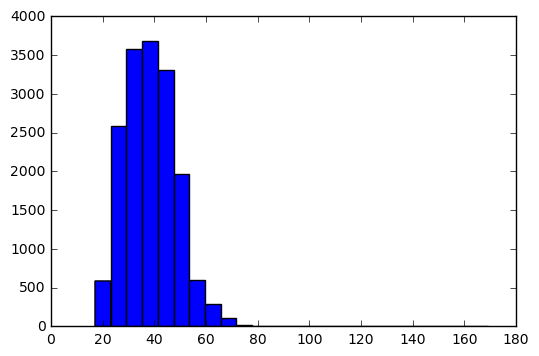

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(map(len,names),bins=25);

# truncate names longer than MAX_LEN characters. 
MAX_LEN = min([60,max(list(map(len,names)))])
#ADJUST IF YOU ARE UP TO SOMETHING SERIOUS


### Cast everything from symbols into identifiers

In [8]:
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

# Input variables

In [9]:
from agentnet import Recurrence
from lasagne.layers import *
from agentnet.memory import *
from agentnet.resolver import ProbabilisticResolver
from gumbel_sigmoid import GumbelSigmoid

In [10]:
sequence = T.matrix('token sequence','int64')

inputs = sequence[:,:-1]
targets = sequence[:,1:]


l_input_sequence = InputLayer(shape=(None, None),input_var=inputs)


# Build NN

You'll be building a model that takes token sequence and predicts next tokens at each tick

This is basically equivalent to how rnn step was described in the lecture

In [11]:
###One step of rnn

class rnn:
    n_hid = 100
    
    #inputs
    inp = InputLayer((None,),name='current character')
    prev_cell = InputLayer((None,n_hid),name='previous lstm cell')
    prev_hid = InputLayer((None,n_hid),name='previous ltsm output')
    
    #recurrent part
    emb = EmbeddingLayer(inp, len(tokens), 30,name='emb')
    
    new_cell,new_hid = LSTMCell(prev_cell,prev_hid,emb,
                                name="rnn") 
    
    next_token_probas = DenseLayer(new_hid,len(tokens),nonlinearity=T.nnet.softmax)
    
    #pick next token from predicted probas
    next_token = ProbabilisticResolver(next_token_probas)
    


### Loss && Training

In [12]:
training_loop = Recurrence(
    state_variables={rnn.new_hid:rnn.prev_hid,
                     rnn.new_cell:rnn.prev_cell},
    input_sequences={rnn.inp:l_input_sequence},
    tracked_outputs=[rnn.next_token_probas,],
    unroll_scan=False,
)

/anaconda3/envs/py27/lib/python2.7/site-packages/agentnet/agent/recurrence.py:188: UserWarning: State_variables recommended type is OrderedDict.
                Otherwise, order of agent state outputs from get_sessions and get_agent_reaction methods
                may depend on python configuration.

                Current order is: [<lasagne.layers.merge.ElemwiseMergeLayer object at 0x7fa19f6a5310>, <lasagne.layers.merge.ElemwiseMergeLayer object at 0x7fa19f6a5650>]
                You may find OrderedDict in standard collections module: from collections import OrderedDict
                
  """.format(state_variables=list(self.state_variables.keys())))
/anaconda3/envs/py27/lib/python2.7/site-packages/agentnet/agent/recurrence.py:300: UserWarning: You are giving Recurrence an input sequence of undefined length (None).
Make sure it is always above <unspecified>(n_steps) you specified for recurrence
  "Make sure it is always above {}(n_steps) you specified for recurrence".format(n_ste

In [13]:
# Model weights
weights = lasagne.layers.get_all_params(training_loop,trainable=True)
print weights

[emb.W, rnn.b_to_ingate, rnn.W_previous ltsm output_to_ingate, rnn.W_emb_to_ingate, rnn.b_to_forgetgate, rnn.W_previous ltsm output_to_forgetgate, rnn.W_emb_to_forgetgate, rnn.b_to_cell, rnn.W_previous ltsm output_to_cell, rnn.W_emb_to_cell, rnn.b_to_outgate, rnn.W_previous ltsm output_to_outgate, rnn.W_emb_to_outgate, rnn.W_cell_to_ingate_peephole.scales, rnn.W_cell_to_forgetgate_peephole.scales, rnn.W_cell_to_outgate_peephole.scales, W, b]


In [14]:
predicted_probabilities = lasagne.layers.get_output(training_loop[rnn.next_token_probas])
#If you use dropout do not forget to create deterministic version for evaluation

loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities.reshape((-1,len(tokens))),
                                                   targets.reshape((-1,))).mean()
#<Loss function - a simple categorical crossentropy will do, maybe add some regularizer>

updates = lasagne.updates.adam(loss,weights)

In [15]:
#training
train_step = theano.function([sequence], loss,
                             updates=training_loop.get_automatic_updates()+updates)

# generation

here we re-wire the recurrent network so that it's output is fed back to it's input

In [16]:
n_steps = T.scalar(dtype='int32')
feedback_loop = Recurrence(
    state_variables={rnn.new_cell:rnn.prev_cell,
                     rnn.new_hid:rnn.prev_hid,
                     rnn.next_token:rnn.inp},
    tracked_outputs=[rnn.next_token_probas,],
    batch_size=1,
    n_steps=n_steps,
    unroll_scan=False,
)
generated_tokens = get_output(feedback_loop[rnn.next_token])
generate_sample = theano.function([n_steps],generated_tokens,updates=feedback_loop.get_automatic_updates())

/anaconda3/envs/py27/lib/python2.7/site-packages/agentnet/agent/recurrence.py:188: UserWarning: State_variables recommended type is OrderedDict.
                Otherwise, order of agent state outputs from get_sessions and get_agent_reaction methods
                may depend on python configuration.

                Current order is: [<lasagne.layers.merge.ElemwiseMergeLayer object at 0x7fa19f6a5310>, <lasagne.layers.merge.ElemwiseMergeLayer object at 0x7fa19f6a5650>, <agentnet.resolver.probabilistic.ProbabilisticResolver object at 0x7fa19f6a5c10>]
                You may find OrderedDict in standard collections module: from collections import OrderedDict
                
  """.format(state_variables=list(self.state_variables.keys())))
/anaconda3/envs/py27/lib/python2.7/site-packages/agentnet/agent/recurrence.py:592: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) i

In [17]:
def generate_string(length=MAX_LEN):
    output_indices = generate_sample(length)[0]
    
    return ''.join(tokens[i] for i in output_indices)
    

In [18]:
generate_string()

'i,!pC6WgxJ,eGR)hJ\'myK6qttUZe2!wzLOu!uUEh[? "),8dYy,rN56Lb/]d'

# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [19]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows

In [20]:

print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=32

loss_history = []

for epoch in xrange(n_epochs):
    avg_cost = 0;
    for _ in range(batches_per_epoch):
        
        avg_cost += train_step(sample_batch(names_ix,batch_size))
    
    loss_history.append(avg_cost)
    print("\n\nEpoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))

    print "Generated names"
    for i in range(10):
        print generate_string(),


Training ...


Epoch 0 average loss = 2.28611750913
Generated names
P/3Hy,Ther,Tmfa:Cin BramcFre Go,                             ,1Br]i]RerntfteraurldhMirrteltt Lurani,                      hb[AnajyOr3Lisannn H,Kegecceade,Bhrnmlu,                     )yNzPra8lGAafueswtryVxyAtowsanGGltg: BolreiurtgelBs Cnsch  G F.o [CnrlulNoect UCtaiN,HatmtasE: Tlilan og:                 JikGg12[P]   Cerr Caeenu:       eeaucytayywhtrtotn:          83L]R Hnmetervu, Cn Wgheoiec Sw  Saoneauern                  kAmrfPpt 2RW]Sotnayh] Ceag   Erameelrndeonger ,evo           xA:5UBRurnlo,GOn:o:CnsaawlQ:s Hert Heretetaky   G            Drd4[Irr-Cu'pa  Aclmte,httbmul  G                            

Epoch 1 average loss = 1.42864778042
Generated names
3[3 B] Creasmuny Bulm Haltas Hreldonliwi'r Satentus          [[5B] Instcant: Nqur Fastaos Ins Rumag                       [3N] CrefParms  Zofanh Dowpar More                           )THcetarene, Gilean Suldnhhore: Hralmhtyand                  21V] Creature,  Hun    

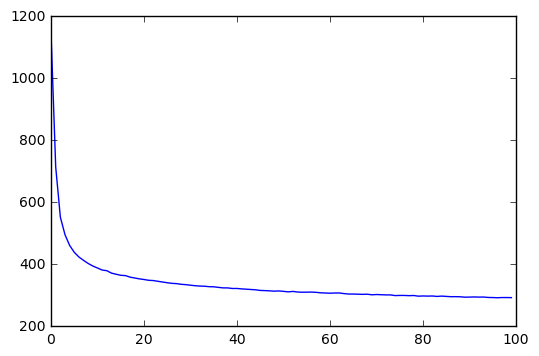

In [21]:
plt.plot(loss_history)

# And now,
* try lstm/gru
* try several layers
* try mtg cards
* try your own dataset of any kind